### Dataset to use - change this value to analyze a different data set

In [1]:
dataset = 'twenty'

### Load in parent probabilities and rates

In [2]:
from analysis import check_gies
import numpy as np

In [3]:
dag_folders = check_gies.get_dag_folders(dataset)
true_dags = check_gies.get_true_dags(dag_folders)
print('loaded DAGs')
parent_probs_by_dag = check_gies.get_parent_probs_by_dag(dag_folders, 10)
print('Computed parent probabilities')

loaded DAGs
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag0
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag7
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag9
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag8
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag6
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag1
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag34
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag33
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag32
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag35
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag44
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag43
/Users/chandlersquires/Documents/active_learning/new/data/twenty/dags/dag19
/Users

### This little section is to check the results from the rates_da. Can be deleted

In [4]:
alphas = np.linspace(0, 1, 11)
avg_tprs = np.zeros(len(alphas))
avg_fprs = np.zeros(len(alphas))
for a_ix, alpha in enumerate(alphas):
    tprs = []
    fprs = []
    for dag_num, (true_dag, parent_probs_by_strat) in enumerate(zip(true_dags, parent_probs_by_dag)):
        true_parents = true_dag.parents[10]
        true_nonparents = true_dag.nodes - true_parents - {10}
        labelled_parents = {p for p, prob in parent_probs_by_strat['learn-parents,n=60,b=2,k=2'].items() if prob >= alpha}
        true_positives = true_parents & labelled_parents
        false_positives = true_nonparents & labelled_parents
        tprs.append(len(true_positives) / len(true_parents) if len(true_parents) != 0 else 1)
        fprs.append(len(false_positives) / len(true_nonparents) if len(true_nonparents) != 0 else 0)
    avg_tprs[a_ix] = np.mean(tprs)
    avg_fprs[a_ix] = np.mean(fprs)

In [5]:
avg_tprs

array([1.   , 0.828, 0.674, 0.556, 0.438, 0.344, 0.256, 0.194, 0.142,
       0.088, 0.01 ])

### Load the rates DataArray, a 7-dimensional tensor mapping each strategy (strategy name, n, b, k) and significance level to the value of a rate for all DAGs

In [6]:
strategy_names = ['random', 'edge-prob', 'learn-parents']
ks = [2]
bs = [2, 3]
ns = [12, 60, 120, 240]
np.linspace(0, 1, 11)

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [7]:
rates_da = check_gies.get_rates_data_array(
    parent_probs_by_dag,
    true_dags,
    target=10,
    strategy_names=strategy_names,
    ks=ks,
    bs=bs,
    ns=ns,
    alphas=np.linspace(0, 1, 11)
)
print(rates_da.dims)

('strategy', 'k', 'b', 'n', 'alpha', 'rate', 'dag')


### Plot curves for each strategy

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
%matplotlib inline
plt.rcParams["figure.figsize"] =(12,9)
sns.set()

In [18]:
linestyles = ['solid', 'dashed', 'dotted']

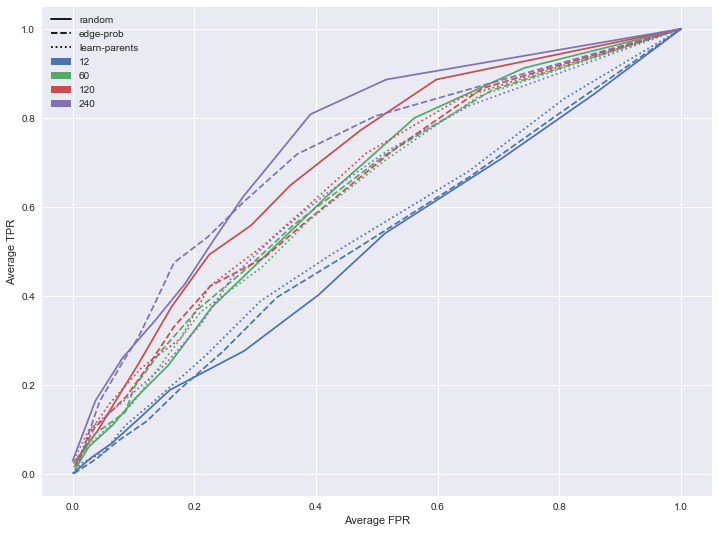

In [19]:
rate_avgs_da = rates_da.mean(dim='dag')
for strategy, linestyle in zip(strategy_names, linestyles):
    for n, color in zip(ns, sns.color_palette()):
        strat_avg_tprs = rate_avgs_da.sel(strategy=strategy, b=3, k=2, n=n, rate='tpr').values
        strat_avg_fprs = rate_avgs_da.sel(strategy=strategy, b=3, k=2, n=n, rate='fpr').values

        sort_ixs = np.argsort(strat_avg_fprs)
        plt.plot(strat_avg_fprs[sort_ixs], strat_avg_tprs[sort_ixs], linestyle=linestyle, color=color)

sample_handles = [
    mpatches.Patch(facecolor=color, label=n)
    for n, color in zip(ns, sns.color_palette())
]
strat_handles = [
    mlines.Line2D([0], [0], color='k', linestyle=linestyle, label=strat) 
    for strat, linestyle in zip(strategy_names, linestyles)
]
plt.legend(
    handles=strat_handles + sample_handles
)
plt.xlabel('Average FPR')
plt.ylabel('Average TPR')
plt.legend();